In [805]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import io
import datetime
import statsmodels.formula.api as smf
import datetime

# Data

In [806]:
df = pd.read_csv('final_project_data.csv', parse_dates = True, index_col = 0)
df.tail(15)

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,US Industrial Index,UK industrial Index
Date,,,,,,
2023-12-12,4.732,4.506,NaN,3.1,NaN,NaN
2023-12-13,4.429,4.365,NaN,NaN,NaN,NaN
2023-12-14,4.389,4.327,NaN,NaN,NaN,NaN
2023-12-15,4.446,4.267,NaN,NaN,NaN,NaN
2023-12-18,4.447,4.296,NaN,NaN,102.4301,93.9
2023-12-19,4.441,4.265,NaN,NaN,NaN,NaN
2023-12-20,4.333,4.089,3.9,NaN,NaN,NaN
2023-12-21,4.348,4.044,NaN,NaN,NaN,NaN
2023-12-22,4.324,4.030,NaN,NaN,NaN,NaN


<Axes: >

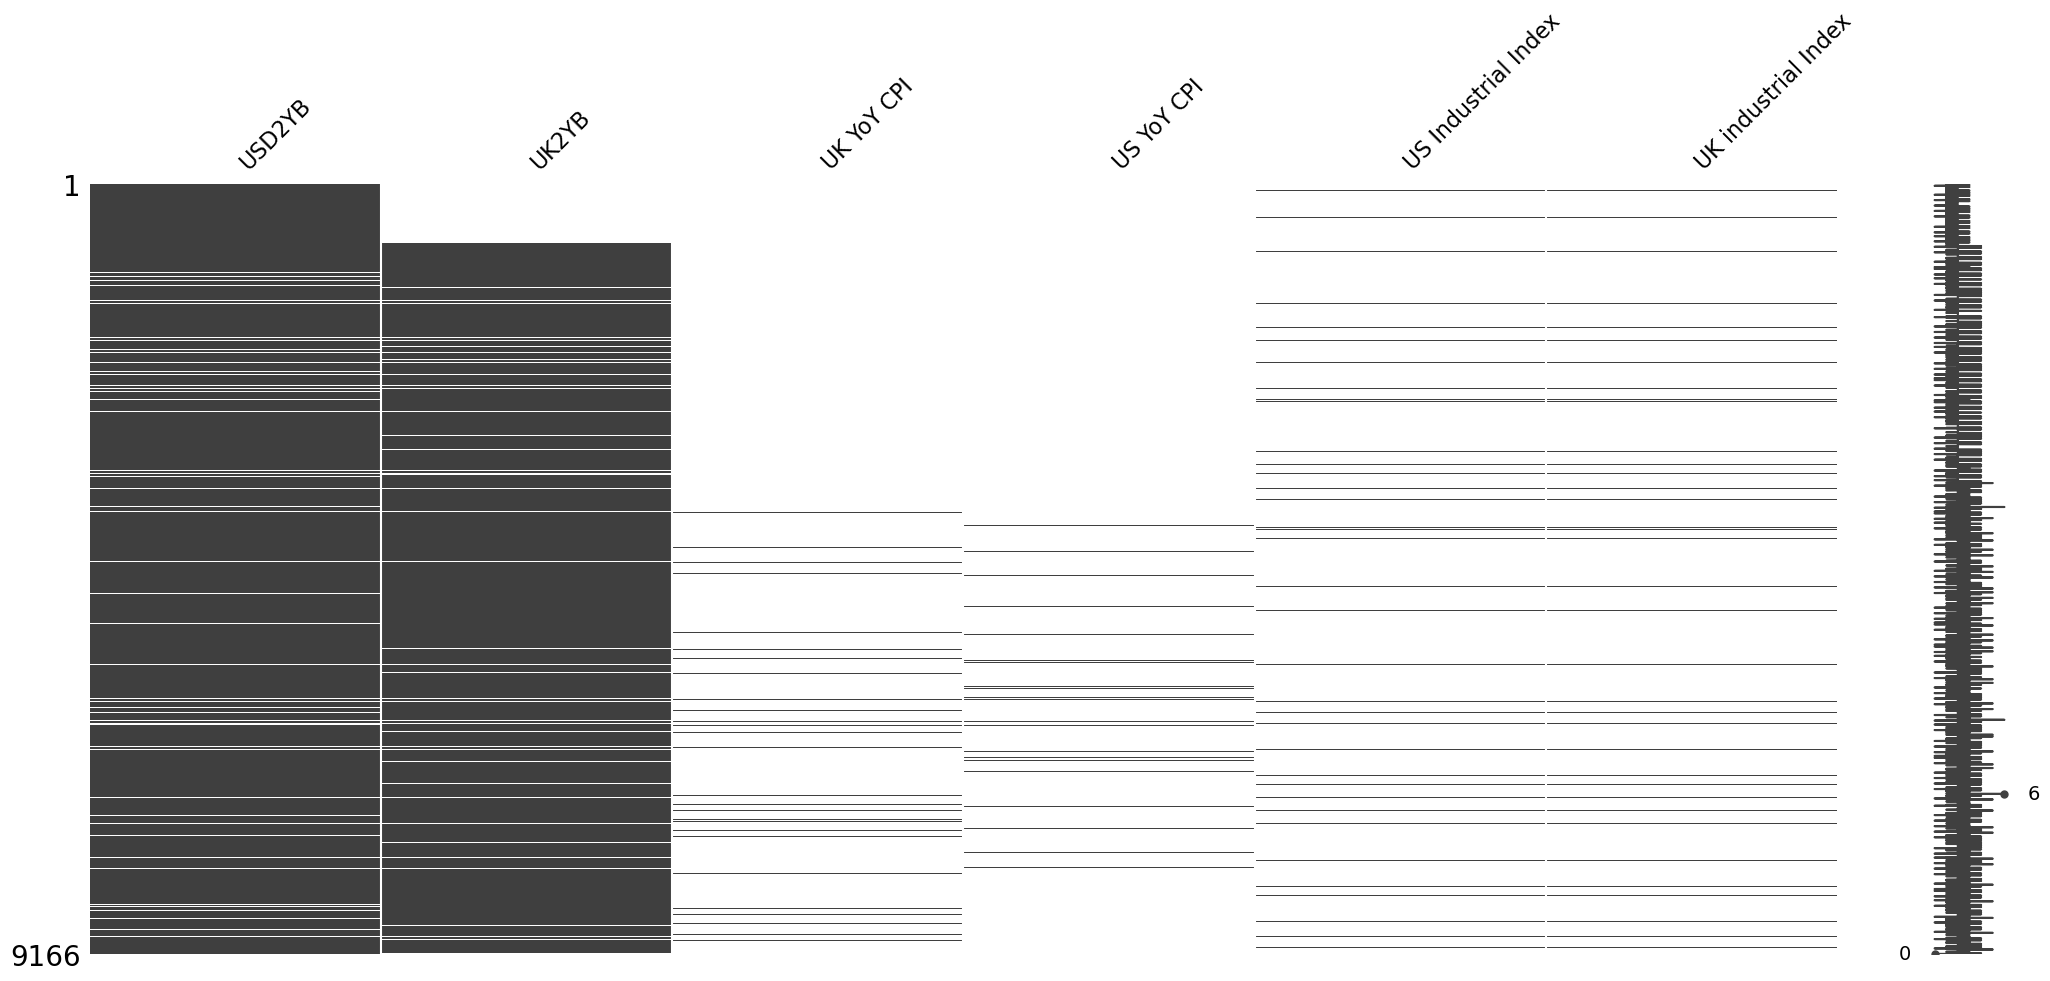

In [807]:
# im gonna see all the missing values in the data
import missingno as msno
msno.matrix(df)

In [808]:
#we find the first value of CPI in order the delet the NaN values that are before that date
initial_date = df['UK YoY CPI'].first_valid_index() 
#.fist_valid_index() returns the first non-NaN value
initial_date

Timestamp('2003-06-17 00:00:00')

In [809]:
#im gonna transform initial_date to first day of the last month 
initial_date = initial_date.replace(day=1)
#We reduce 1 month to this date
initial_date = initial_date - pd.DateOffset(months=1)
initial_date

Timestamp('2003-05-01 00:00:00')

In [810]:
#Lets transform the date to a string, keeping the format YYYY-DD-MM
initial_date_2 = initial_date.strftime('%Y-%m-%d')
initial_date_2

'2003-05-01'

In [811]:
ticker = "USDGBP=X"
usd_to_gbp_rate = yf.download(ticker, start=initial_date_2, end=df.index[-1].strftime('%Y-%m-%d'))

[*********************100%%**********************]  1 of 1 completed


In [812]:
usd_to_gbp_rate.head(4)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,0.58011,0.58194,0.57897,0.58187,0.58187,0
2003-12-02,0.58173,0.58231,0.57733,0.57793,0.57793,0
2003-12-03,0.57787,0.57964,0.57743,0.57867,0.57867,0
2003-12-04,0.57890,0.58197,0.57837,0.58116,0.58116,0


In [813]:
#we are gonna drop all the values before initial_date
df = df[initial_date:]
df.head()

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,US Industrial Index,UK industrial Index
Date,,,,,,
2003-05-01,1.469,3.572,NaN,NaN,NaN,NaN
2003-05-02,1.565,3.631,NaN,NaN,NaN,NaN
2003-05-05,1.533,NaN,NaN,NaN,NaN,NaN
2003-05-06,1.428,3.644,NaN,NaN,NaN,NaN
2003-05-07,1.412,3.585,NaN,NaN,NaN,NaN


In [814]:
#Im gonna try transform USD2YB and UK2YB to a daily frequency
df['USD2YB'] = ((df['USD2YB']/100)+1)**(1/126)
df['UK2YB'] = ((df['UK2YB']/100)+1)**(1/126)

In [815]:
#Im gonna transform the USD2YB and UK2YB to a log return
df['USD2YB'] = np.log(df['USD2YB'])
df['UK2YB'] = np.log(df['UK2YB'])


In [816]:
nan_values = df.isnull().sum()
print("NaN values in each column:")
print(nan_values)



NaN values in each column:
USD2YB                  299
UK2YB                   246
UK YoY CPI             5221
US YoY CPI             5220
US Industrial Index    5219
UK industrial Index    5220
dtype: int64


In [817]:
#Im gonna calculate the log return of the exchange rate
usd_to_gbp_rate = usd_to_gbp_rate.copy()

usd_to_gbp_rate['log_return'] = np.log(usd_to_gbp_rate['Adj Close']) - np.log(usd_to_gbp_rate['Adj Close'].shift(1))
#were gonna drop the first value of the log return
usd_to_gbp_rate = usd_to_gbp_rate.dropna()
#we keep only the columns Adj Close and log_return
usd_to_gbp_rate = usd_to_gbp_rate[['Adj Close', 'log_return']]

In [818]:
initial_date_3 = usd_to_gbp_rate['Adj Close'].first_valid_index() 
initial_date_3

Timestamp('2003-12-02 00:00:00')

In [819]:
df = df.merge(usd_to_gbp_rate["log_return"], left_index=True, right_index=True, how='left')

In [820]:
df.head(15)

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,US Industrial Index,UK industrial Index,log_return
Date,,,,,,,
2003-05-01,0.000116,0.000279,NaN,NaN,NaN,NaN,NaN
2003-05-02,0.000123,0.000283,NaN,NaN,NaN,NaN,NaN
2003-05-05,0.000121,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-06,0.000113,0.000284,NaN,NaN,NaN,NaN,NaN
2003-05-07,0.000111,0.000280,NaN,NaN,NaN,NaN,NaN
2003-05-08,0.000115,0.000284,NaN,NaN,NaN,NaN,NaN
2003-05-09,0.000114,0.000286,NaN,NaN,NaN,NaN,NaN
2003-05-12,0.000113,0.000284,NaN,NaN,NaN,NaN,NaN
2003-05-13,0.000114,0.000282,NaN,NaN,NaN,NaN,NaN


In [821]:
#Im gonna resample the data to a monthly frequency. For USD2YB and UK2YB we are gonna use the sum of the log returns, and for the rest of the columns we are gonna use the last value of the month.

df2 = df.resample('M').agg({'USD2YB':'sum', 'UK2YB':'sum', 'UK YoY CPI':'last', 'US YoY CPI':'last', 'UK industrial Index':'last', 'US Industrial Index':'last', 'log_return':'sum'})
df2

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,UK industrial Index,US Industrial Index,log_return
Date,,,,,,,
2003-05-31,0.002300,0.005518,NaN,2.2,101.1,90.4281,0.000000
2003-06-30,0.002001,0.005601,1.2,2.1,99.8,90.4073,0.000000
2003-07-31,0.002527,0.006387,1.1,2.1,100.4,90.5218,0.000000
2003-08-31,0.003007,0.006292,1.3,2.1,101.0,90.9896,0.000000
2003-09-30,0.002777,0.007110,1.4,2.2,101.2,90.7858,0.000000
...,...,...,...,...,...,...,...
2023-09-30,0.007813,0.008113,6.7,3.7,95.0,103.2411,0.040701
2023-10-31,0.008264,0.008272,6.7,3.7,94.9,103.3346,0.003205
2023-11-30,0.007962,0.007883,4.6,3.2,93.7,102.4592,-0.042694


In [822]:
#We create a column of the difference between USD2YB and UK2YB
df2['Y_diff'] = df2['USD2YB'] - df2['UK2YB']

In [823]:
#Transform USD2YB and UK2YB to simple returns
df2['USD2YB'] = np.exp(df2['USD2YB'])-1
df2['UK2YB'] = np.exp(df2['UK2YB'])-1

In [824]:
# Specify the columns to be shifted
columns_to_shift = ['UK YoY CPI', 'US YoY CPI', 'US Industrial Index', 'UK industrial Index']

# Shift the specified columns using .shift(-1)
df2[columns_to_shift] = df2[columns_to_shift].shift(-1)

# Display the resulting DataFrame with shifted columns
df2

,USD2YB,UK2YB,UK YoY CPI,US YoY CPI,UK industrial Index,US Industrial Index,log_return,Y_diff
Date,,,,,,,,
2003-05-31,0.002302,0.005534,1.2,2.1,99.8,90.4073,0.000000,-0.003219
2003-06-30,0.002003,0.005616,1.1,2.1,100.4,90.5218,0.000000,-0.003600
2003-07-31,0.002530,0.006407,1.3,2.1,101.0,90.9896,0.000000,-0.003860
2003-08-31,0.003011,0.006312,1.4,2.2,101.2,90.7858,0.000000,-0.003285
2003-09-30,0.002781,0.007135,1.4,2.3,101.4,91.3829,0.000000,-0.004333
...,...,...,...,...,...,...,...,...
2023-09-30,0.007844,0.008146,6.7,3.7,94.9,103.3346,0.040701,-0.000300
2023-10-31,0.008298,0.008307,4.6,3.2,93.7,102.4592,0.003205,-0.000009
2023-11-30,0.007994,0.007914,3.9,3.1,93.9,102.4301,-0.042694,0.000079


In [825]:
#we get rid of the last two rows of the dataframes
df2 = df2[:-2]

In [826]:
df2.isnull().sum()

USD2YB                 0
UK2YB                  0
UK YoY CPI             0
US YoY CPI             0
UK industrial Index    0
US Industrial Index    0
log_return             0
Y_diff                 0
dtype: int64

# Data Preparation

In [827]:
df2 = df2.copy()
df2.reset_index(inplace=True)
df2.rename(columns={'UK industrial Index': 'UK_Industrial_Index', 'US Industrial Index': 'US_Industrial_Index',
                    'UK YoY CPI': 'UK_YoY_CPI', 'US YoY CPI': 'US_YoY_CPI'}, inplace=True)
df2

,Date,USD2YB,UK2YB,UK_YoY_CPI,US_YoY_CPI,UK_Industrial_Index,US_Industrial_Index,log_return,Y_diff
0,2003-05-31,0.002302,0.005534,1.2,2.1,99.8,90.4073,0.000000,-0.003219
1,2003-06-30,0.002003,0.005616,1.1,2.1,100.4,90.5218,0.000000,-0.003600
2,2003-07-31,0.002530,0.006407,1.3,2.1,101.0,90.9896,0.000000,-0.003860
3,2003-08-31,0.003011,0.006312,1.4,2.2,101.2,90.7858,0.000000,-0.003285
4,2003-09-30,0.002781,0.007135,1.4,2.3,101.4,91.3829,0.000000,-0.004333
...,...,...,...,...,...,...,...,...,...
242,2023-07-31,0.007547,0.008385,6.8,3.2,95.4,103.1900,-0.018795,-0.000831
243,2023-08-31,0.008801,0.008640,6.7,3.7,95.0,103.2411,0.011122,0.000159
244,2023-09-30,0.007844,0.008146,6.7,3.7,94.9,103.3346,0.040701,-0.000300
245,2023-10-31,0.008298,0.008307,4.6,3.2,93.7,102.4592,0.003205,-0.000009


In [828]:
df2.head(15)

,Date,USD2YB,UK2YB,UK_YoY_CPI,US_YoY_CPI,UK_Industrial_Index,US_Industrial_Index,log_return,Y_diff
0,2003-05-31,0.002302,0.005534,1.2,2.1,99.8,90.4073,0.000000,-0.003219
1,2003-06-30,0.002003,0.005616,1.1,2.1,100.4,90.5218,0.000000,-0.003600
2,2003-07-31,0.002530,0.006407,1.3,2.1,101.0,90.9896,0.000000,-0.003860
3,2003-08-31,0.003011,0.006312,1.4,2.2,101.2,90.7858,0.000000,-0.003285
4,2003-09-30,0.002781,0.007135,1.4,2.3,101.4,91.3829,0.000000,-0.004333
5,2003-10-31,0.002981,0.007899,1.4,2.0,103.2,91.5005,0.000000,-0.004892
6,2003-11-30,0.002685,0.007095,1.3,1.8,101.8,92.1265,0.000000,-0.004388
7,2003-12-31,0.003257,0.007173,1.3,1.9,101.8,92.1722,-0.040151,-0.003896
8,2004-01-31,0.002716,0.007045,1.4,1.9,103.1,92.3270,-0.022203,-0.004307
9,2004-02-29,0.002558,0.006693,1.3,1.7,102.8,92.8873,-0.023940,-0.004116


In [829]:
### Data Cleaning : Use observations from 1973M3 to October 2022
## Dependent Variable : s_t+1, s_t
# s_current : log of nominal exchange rates at t
#We are gonna use the first 26 months to calculate the thrend
s_change = df2.loc[26:len(df2)-2,'log_return'].reset_index(drop=True) #Why reset index? To combine into a single data set later
s_change = s_change.rename('s_change')

In [830]:
#We create a moving average of Y_diff
windows = 6
df2['Y_diff_MA'] = df2['Y_diff'].rolling(window=windows).mean()
#Now we only keep from the 26th value
Y_diff = df2.loc[26:len(df2)-2,'Y_diff_MA'].reset_index(drop=True)
Y_diff = Y_diff.rename('Y_diff')

In [831]:

## Independent Variables
# inf_us, inf_df2 : us inflation at t, df2 inflation at t
inf_df2 = df2.loc[26:len(df2)-2,'UK_YoY_CPI'].reset_index(drop=True)
inf_us = df2.loc[26:len(df2)-2,'US_YoY_CPI'].reset_index(drop=True)
inf_diff = inf_us - inf_df2
inf_diff = inf_diff.rename('inf_diff')

# inf_us, inf_df2 : us inflation at t, df2 inflation at t
yield_df2 = df2.loc[26:len(df2)-2,'UK2YB'].reset_index(drop=True)
yield_us = df2.loc[26:len(df2)-2,'USD2YB'].reset_index(drop=True)
yield_diff = yield_us - yield_df2
yield_diff = yield_diff.rename('yield_diff')



# output_us, output_df2 : us output at t, df2 output at t
output_uk = df2.loc[26:len(df2)-2,'UK_Industrial_Index'].reset_index(drop=True)
output_us = df2.loc[26:len(df2)-2,'US_Industrial_Index'].reset_index(drop=True)


# date : Time at t+1
date = df2.loc[27:,'Date'].reset_index(drop=True)


# Combine all variables into a new data set
df2_const = pd.concat([date,  s_change, inf_diff, output_uk, output_us,yield_diff,Y_diff], axis=1)
df2_const.head(10)

,Date,s_change,inf_diff,UK_Industrial_Index,US_Industrial_Index,yield_diff,Y_diff
0,2005-08-31,0.018079,0.9,99.9,96.8383,-0.000712,-0.001280
1,2005-09-30,-0.025374,1.2,99.1,97.1603,0.000010,-0.000916
2,2005-10-31,0.021745,2.2,100.5,95.2729,-0.000693,-0.000792
3,2005-11-30,-0.002367,2.0,99.5,96.4383,-0.000316,-0.000588
4,2005-12-31,0.021644,1.4,100.8,97.4951,-0.000586,-0.000547
5,2006-01-31,0.004309,1.4,104.2,97.9788,0.000476,-0.000302
6,2006-02-28,-0.033974,2.1,102.8,98.1305,-0.000119,-0.000203
7,2006-03-31,0.013813,1.6,102.7,98.1779,0.000210,-0.000170
8,2006-04-30,0.009445,1.6,103.9,98.3898,0.000549,0.000035
9,2006-05-31,-0.049726,1.5,104.1,98.6769,0.000882,0.000234


In [832]:
len(df2)

247

# Strategy

In [833]:
## Estimate of Output Gap
# Linear Trend
# Output Gap in df2 and US

df2_const = df2_const.copy()
df2 = df2.copy()
df2_const.rename(columns={'UK industrial Index': 'UK_Industrial_Index', 'US Industrial Index': 'US_Industrial_Index'}, inplace=True)

df2['t'] = pd.DataFrame({'t' : range(1,len(df2)+1)})

for i in range(0,len(df2_const)): # Updating the potential output each period
    
    # note that we are expanding the traning set each loop, starting from 0:27
    linear_trend_df2 = smf.ols(formula = 'UK_Industrial_Index ~ t', data=df2[0:27+i]).fit()
    
    # we make a prediction for the next period
    df2_const.loc[i,'df2_potential'] = linear_trend_df2.predict(df2['t'][27+i:28+i])[27+i]
    
    # Repeat for the US
    linear_trend_us = smf.ols(formula = 'US_Industrial_Index ~ t', data=df2[0:27+i]).fit()
    df2_const.loc[i,'us_potential'] = linear_trend_us.predict(df2['t'][27+i:28+i])[27+i]
    
df2_const['df2_gap'] = (df2_const['UK_Industrial_Index'] - df2_const['df2_potential'])/df2_const['df2_potential']
df2_const['us_gap'] = (df2_const['US_Industrial_Index'] - df2_const['us_potential'])/df2_const['us_potential']


# Output Gap differential between US and df2
df2_const['gap_diff'] = df2_const['us_gap'] - df2_const['df2_gap']


# Keep variables only used for our model
df2_const=df2_const[['Date', 's_change', 'inf_diff', 'gap_diff', 'yield_diff','Y_diff']]

In [834]:
## Make sure all columns have float numbers
df2_const.loc[:,'s_change'] = df2_const.loc[:,'s_change'].apply(float)
df2_const.loc[:,'inf_diff'] = df2_const.loc[:,'inf_diff'].apply(float)
df2_const.loc[:,'gap_diff'] = df2_const.loc[:,'gap_diff'].apply(float)
df2_const.loc[:,'yield_diff'] = df2_const.loc[:,'yield_diff'].apply(float)

df2_const.loc[:,'Y_diff'] = df2_const.loc[:,'Y_diff'].apply(float)

In [835]:
df2_const.head(10)

,Date,s_change,inf_diff,gap_diff,yield_diff,Y_diff
0,2005-08-31,0.018079,0.9,-0.005750,-0.000712,-0.001280
1,2005-09-30,-0.025374,1.2,0.001267,0.000010,-0.000916
2,2005-10-31,0.021745,2.2,-0.031240,-0.000693,-0.000792
3,2005-11-30,-0.002367,2.0,-0.011365,-0.000316,-0.000588
4,2005-12-31,0.021644,1.4,-0.015100,-0.000586,-0.000547
5,2006-01-31,0.004309,1.4,-0.041713,0.000476,-0.000302
6,2006-02-28,-0.033974,2.1,-0.025883,-0.000119,-0.000203
7,2006-03-31,0.013813,1.6,-0.024263,0.000210,-0.000170
8,2006-04-30,0.009445,1.6,-0.032689,0.000549,0.000035
9,2006-05-31,-0.049726,1.5,-0.030624,0.000882,0.000234


### (b) Run regressions to generate the forecasts of exchange rates based on the Taylor rule

In [836]:
# Create empty columns for fitted values of changes i.e. changes of log exchange rates
df2_const['s_change_fitted'] = np.nan

# Out-of-sample Forecasts with rolling window : Here, we use the first 120 observations
for i in range(120,len(df2_const)):
    #We nowcast inf_diff using yield_diff (interest rate differential) and Y_diff (moving average of yield differential)
    tmp2 = smf.ols(formula = 'inf_diff ~ yield_diff + Y_diff', data=df2_const[i-120:i-1]).fit()
    df4 = df2_const.copy()
    df4.loc[i-1,'inf_diff'] = tmp2.predict(df2_const[['yield_diff', 'Y_diff']][i-1:i])[i-1]
    tmp3 = smf.ols(formula = 'gap_diff ~ yield_diff + Y_diff', data=df2_const[i-120:i-1]).fit()
    df4.loc[i-1,'gap_diff'] = tmp3.predict(df2_const[['yield_diff', 'Y_diff']][i-1:i])[i-1]


    # we regress the change in teh exchange rate on the taylor rule fundamentals
    tmp = smf.ols(formula = 's_change ~ inf_diff + gap_diff', data=df4[i-120:i]).fit()
    
    # make a prediction for the next period
    df2_const.loc[i,'s_change_fitted'] = tmp.predict(df4[['inf_diff', 'gap_diff']][i:i+1])[i]

# # Forecasts
# df2_const['s_forecast'] = df2_const['s_change_fitted'] + df2_const['s_current']

# Forecast Error
df2_const['error'] = df2_const['s_change']-df2_const['s_change_fitted']


df2_const.tail(10)

,Date,s_change,inf_diff,gap_diff,yield_diff,Y_diff,s_change_fitted,error
210,2023-02-28,-0.019064,-3.7,0.015014,0.000936,0.001258,-0.005514,-0.013550
211,2023-03-31,0.023925,-4.4,0.015518,0.001058,0.001112,-0.009238,0.033162
212,2023-04-30,-0.026646,-5.1,0.008395,0.001492,0.001251,-0.014803,-0.011843
213,2023-05-31,-0.010793,-3.8,0.011493,0.000905,0.001271,-0.005957,-0.004836
214,2023-06-30,0.009193,-4.7,0.016956,0.000896,0.001149,-0.009607,0.018800
215,2023-07-31,-0.016204,-4.9,-0.015839,-0.000680,0.000763,-0.013759,-0.002445
216,2023-08-31,-0.018795,-3.6,0.002941,-0.000838,0.000469,-0.005826,-0.012969
217,2023-09-30,0.011122,-3.0,0.007071,0.000160,0.000321,-0.003609,0.014731
218,2023-10-31,0.040701,-3.0,0.008419,-0.000302,0.000024,-0.003272,0.043973
219,2023-11-30,0.003205,-1.4,0.011864,-0.000009,-0.000128,0.004651,-0.001447


In [837]:
df3 = df2_const.dropna()
df3 = df3.copy()

# Go long if we forecast the exchange rate will increase, otherwise short
df3['signal'] = np.where(df3['s_change_fitted'] >= 0, 1, -1)

# calculate returns
df3['returns'] = np.exp(df3['signal']*s_change)
df3['strategy_return'] = (np.exp((df3['signal']*s_change).cumsum())-1)*100


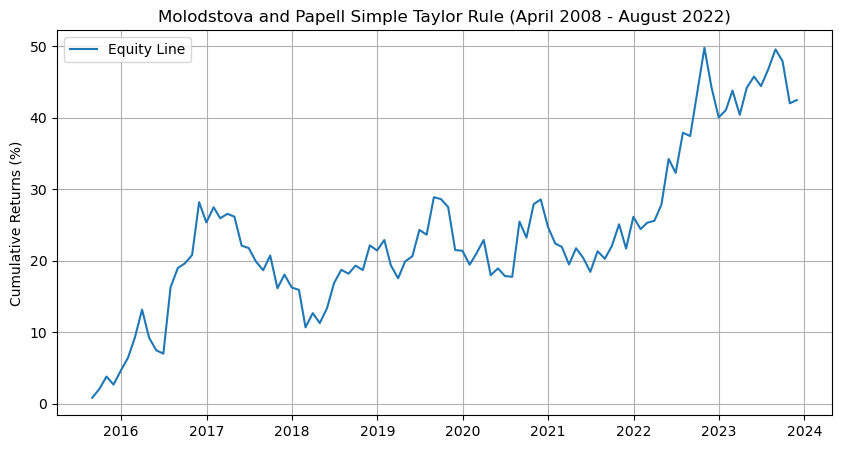

In [838]:
import matplotlib.pyplot as plt
df3c = df3.copy()
df3c.index = pd.to_datetime(df3c.Date)
plt.figure(figsize = (10, 5))
plt.plot(df3c['strategy_return'])
plt.ylabel("Cumulative Returns (%)")
#Check the title!!
plt.title("Molodstova and Papell Simple Taylor Rule (April 2008 - August 2022)")

plt.legend(["Equity Line"])
plt.grid()

In [839]:
#Im gonna get the annualized return
annualized_return = (np.power(((df3['strategy_return'].iloc[-1]/100)+1), 12/len(df3))-1)*100
annualized_return

4.33934006997827